In [1]:
import numpy as np
import pandas as pd
from pandas.io import sql
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import rcParams
from pylab import rcParams
import seaborn as sns

In [2]:
sns.set()
rcParams['font.sans-serif'] = ['Inconsolata']
rcParams["legend.borderpad"] = .5
rcParams['figure.figsize'] = 16, 10
SMALL_SIZE = 8
MEDIUM_SMALL_SIZE = 10
MEDIUM_SIZE = 10
MEDIUM_LARGE_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
%load_ext dotenv
%dotenv ../.env

In [4]:
cnx = create_engine(os.getenv('EDMDB'))

#### Part 1: Regular Lots

How many regular lots are there?

In [5]:
regular_lot_count = pd.read_sql_query('''SELECT COUNT(*)
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N';''', cnx)
regular_lot_count

,count
0,722087


Of the regular lots, how many have lot areas equal to the lot front times the lot depth, and how many don't?

In [6]:
regular_lotarea = pd.read_sql_query('''WITH regular_lotarea AS (
SELECT "BBL",
CASE
    WHEN "LotArea" = ROUND("LotFront" * "LotDepth") THEN 'Y'
    ELSE 'N'
END AS regular_lotarea_ind
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N'
)
SELECT regular_lotarea_ind, COUNT(*)
FROM regular_lotarea
GROUP BY regular_lotarea_ind;''', cnx)
regular_lotarea

,regular_lotarea_ind,count
0,N,63704
1,Y,658383


For the lots with illogical lot areas, how many of them are equal to the rounded ESRI shape area?

In [7]:
lotarea_eq_shape = pd.read_sql_query('''SELECT COUNT(*)
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N'
AND "LotArea" <> ROUND("LotFront" * "LotDepth")
AND "LotArea" = ROUND("Shape_Area");''', cnx)
lotarea_eq_shape

,count
0,1593


In [8]:
landuse_reg_breakout = pd.read_sql_query('''SELECT "LandUse",
COALESCE(def, 'NULL') AS def,
SUM("LotArea") AS "LotArea",
SUM(ROUND("LotFront" * "LotDepth")) AS "FrontxDepth",
SUM(ROUND("Shape_Area")) AS "ShapeArea",
SUM(ROUND(("LotFront" * "LotDepth")) - "LotArea") AS Diff_LotArea_FxD,
SUM(ROUND("Shape_Area") - "LotArea") AS Diff_LotArea_SA
FROM dcp.mappluto_unclipped p
LEFT JOIN dcp.landuse_definitions l
ON p."LandUse" = l.landuse
WHERE "IrrLotCode" = 'N'
AND "LotArea" <> ROUND("LotFront" * "LotDepth")
AND "LotArea" <> ROUND("Shape_Area")
GROUP BY "LandUse", def;''', cnx)
landuse_reg_breakout

,LandUse,def,LotArea,FrontxDepth,ShapeArea,diff_lotarea_fxd,diff_lotarea_sa
0,01,One and Two Family Buildings,95198498,98576886.0,95462865.0,3378388.0,264367.0
1,02,Multi-Family Walkup Buildings,52994701,43072524.0,53440117.0,-9922177.0,445416.0
2,03,Multi-Family Elevator Buildings,39645043,35780523.0,40746515.0,-3864520.0,1101472.0
3,04,Mixed Residential and Commercial,40330811,32119574.0,41353377.0,-8211237.0,1022566.0
4,05,Commercial and Office,30524204,28403270.0,31266968.0,-2120934.0,742764.0
5,06,Industrial and Manufacturing,15960965,15437897.0,16503082.0,-523068.0,542117.0
6,07,Transportation and Utility,22111909,15155976.0,24412086.0,-6955933.0,2300177.0
7,08,Public Facilities and Institutions,42247847,34585532.0,44896563.0,-7662315.0,2648716.0
8,09,Open Space and Outdoor Recreation,82140915,51311013.0,90971026.0,-30829902.0,8830111.0
9,10,Parking Facilities,8352525,8330220.0,8501822.0,-22305.0,149297.0


In [9]:
def x_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = round(int(tick_val) /1000000000, 1)
        return '{}B'.format(val)
    elif tick_val > 1000000:
        val = round(int(tick_val) /1000000)
        return '{}M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{}k'.format(val)
    else:
        return tick_val

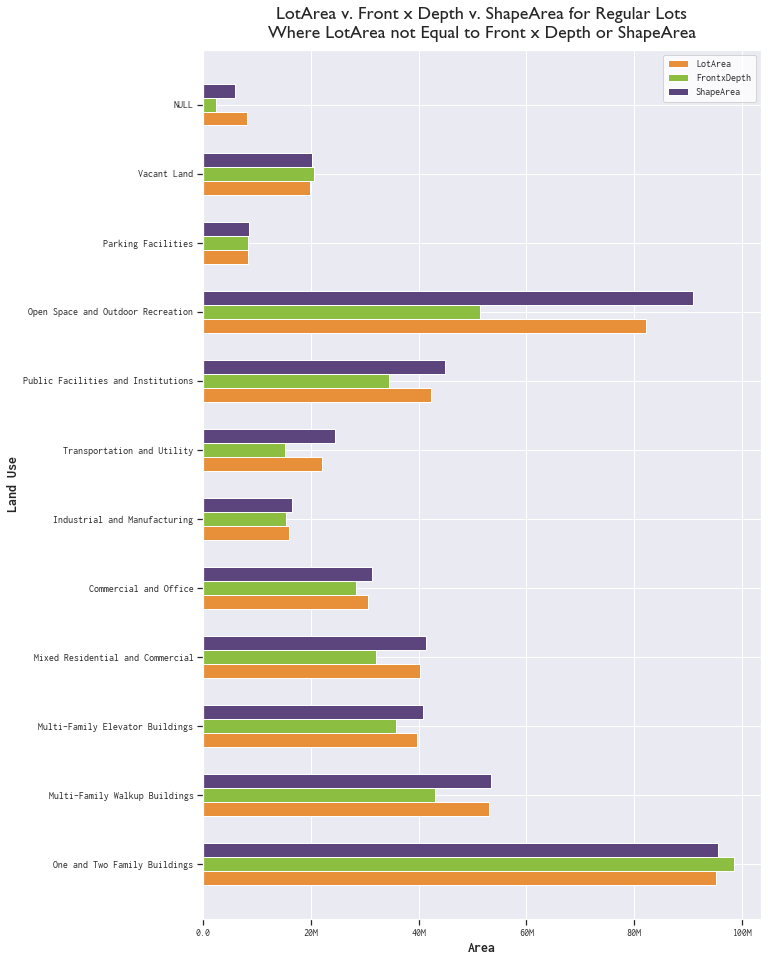

In [16]:
lotarea = landuse_reg_breakout['LotArea'].to_list()
frontxdepth = landuse_reg_breakout['FrontxDepth'].to_list()
shapearea = landuse_reg_breakout['ShapeArea'].to_list()
landuse = landuse_reg_breakout['def'].to_list()
df = pd.DataFrame(dict(graph=landuse,
                           n=lotarea, m=frontxdepth, o=shapearea)) 

ind = np.arange(len(df))
width = 0.2

fig, ax = plt.subplots(figsize=(10,16))
ax.barh(ind, df.n, width, color='#e88f39', label='LotArea')
ax.barh(ind + width, df.m, width, color='#8cbf41', label='FrontxDepth')
ax.barh(ind + width + width, df.o, width, color='#5c447c', label='ShapeArea')

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)], xticklabels=df.n)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
ax.set_xlabel("Area", fontweight="bold")
ax.set_ylabel("Land Use", fontweight="bold")
ax.tick_params(left=True, bottom=True)
plt.legend(loc='upper right', shadow='bool')
ax.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title('LotArea v. Front x Depth v. ShapeArea for Regular Lots\nWhere LotArea not Equal to Front x Depth or ShapeArea', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()

#### Part 2: Irregular Lots

How many irregular lots are there?

In [11]:
irregular_lot_count = pd.read_sql_query('''SELECT COUNT(*)
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'Y';''', cnx)
irregular_lot_count

,count
0,134954


Of the irregular lots, how many have lots equal the shape area, and how many don't?

In [12]:
irregular_lotarea = pd.read_sql_query('''WITH irregular_lotarea AS (
SELECT "BBL",
CASE
    WHEN ROUND("LotArea") = ROUND("Shape_Area") THEN 'Y'
    ELSE 'N'
END AS lotarea_ind
FROM dcp.mappluto_unclipped
WHERE "IrrLotCode" = 'N'
)
SELECT lotarea_ind, COUNT(*)
FROM irregular_lotarea
GROUP BY lotarea_ind;''', cnx)
irregular_lotarea

,lotarea_ind,count
0,N,709631
1,Y,12456


In [13]:
landuse_irreg_breakout = pd.read_sql_query('''SELECT "LandUse",
COALESCE(def, 'NULL') AS def,
SUM("LotArea") AS "LotArea",
SUM(ROUND("Shape_Area")) AS "ShapeArea",
SUM(ROUND("Shape_Area") - "LotArea") AS Diff_LotArea_SA
FROM dcp.mappluto_unclipped p
LEFT JOIN dcp.landuse_definitions l
ON p."LandUse" = l.landuse
WHERE "IrrLotCode" = 'Y'
AND "LotArea" <> ROUND("Shape_Area")
GROUP BY "LandUse", def;''', cnx)
landuse_irreg_breakout

,LandUse,def,LotArea,ShapeArea,diff_lotarea_sa
0,01,One and Two Family Buildings,285881676,2.935749e+08,7693244.0
1,02,Multi-Family Walkup Buildings,130759543,1.299365e+08,-823001.0
2,03,Multi-Family Elevator Buildings,241311275,2.409148e+08,-396452.0
3,04,Mixed Residential and Commercial,105571548,1.039476e+08,-1623944.0
4,05,Commercial and Office,191100619,1.962494e+08,5148791.0
5,06,Industrial and Manufacturing,171319541,1.741818e+08,2862264.0
6,07,Transportation and Utility,459069511,4.813096e+08,22240112.0
7,08,Public Facilities and Institutions,431363555,4.318925e+08,528934.0
8,09,Open Space and Outdoor Recreation,1503021777,1.733781e+09,230758900.0
9,10,Parking Facilities,52625109,5.243349e+07,-191616.0


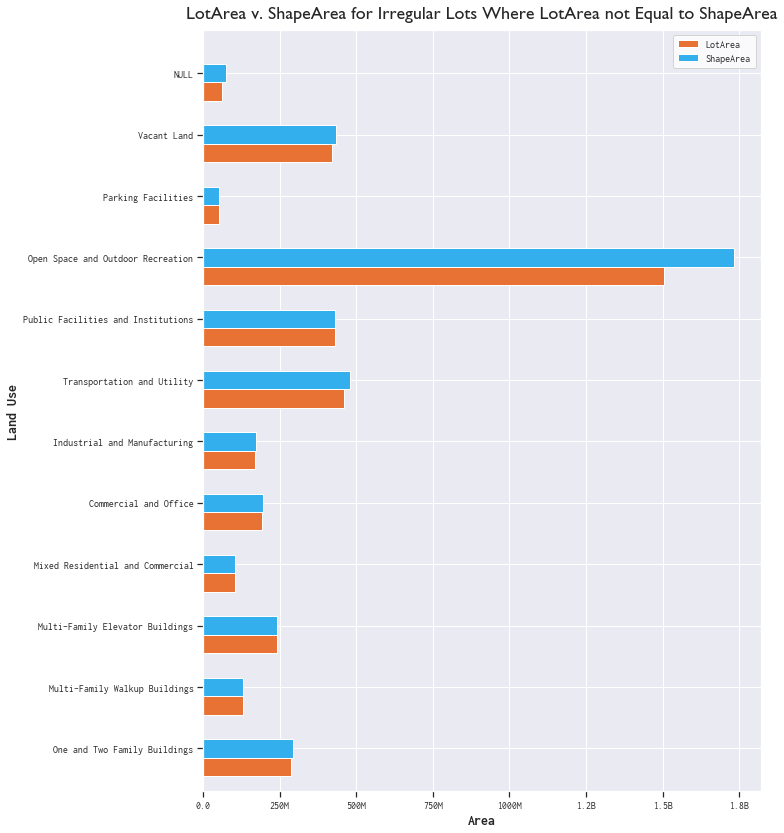

In [17]:
lotarea = landuse_irreg_breakout['LotArea'].to_list()
shapearea = landuse_irreg_breakout['ShapeArea'].to_list()
landuse = landuse_irreg_breakout['def'].to_list()
df = pd.DataFrame(dict(graph=landuse,
                           m=lotarea, n=shapearea)) 

ind = np.arange(len(df))
width = 0.3

fig, ax = plt.subplots(figsize=(10,14))
ax.barh(ind, df.m, width, color='#e87233', label='LotArea')
ax.barh(ind + width, df.n, width, color='#34afed', label='ShapeArea')

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)], xticklabels=df.n)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
ax.set_xlabel("Area", fontweight="bold")
ax.set_ylabel("Land Use", fontweight="bold")
ax.tick_params(left=True, bottom=True)
plt.legend(loc='upper right', shadow='bool')
ax.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title('LotArea v. ShapeArea for Irregular Lots Where LotArea not Equal to ShapeArea', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()

#### Part 3: Impact of Replacing LotArea with Shape_Area for IrrLotCode Correction